## Climate Impact Lab Global Downscaled Projections for Climate Impacts Research

The Climate Impact Lab Downscaled Projections for Climate Impacts Research (CIL-GDPCR) collections contain bias corrected and downscaled 1/4° CMIP6 projections for temperature and precipitation.

See the project homepage for more information: [github.com/ClimateImpactLab/downscaleCMIP6](https://github.com/ClimateImpactLab/downscaleCMIP6).

This tutorial covers accessing the STAC API to explore the collections and open a dataset. Additional tutorials are available at [github.com/microsoft/PlanetaryComputerExamples](https://github.com/microsoft/PlanetaryComputerExamples/blob/main/datasets/cil-gdpcir).


In [1]:
import planetary_computer
import pystac_client

### STAC Metadata

The [CIL-GDPR datsets](https://planetarycomputer.microsoft.com/dataset/group/cil-gdpcir) are grouped into several collections, depending on the license the data are provided under.

- [CIL-GDPCIR-CC0](https://planetarycomputer.microsoft.com/dataset/cil-gdpcir-cc0)
- [CIL-GDPCIR-CC-BY](https://planetarycomputer.microsoft.com/dataset/cil-gdpcir-cc-by)
- [CIL-GDPCIR-CC-BY-SA](https://planetarycomputer.microsoft.com/dataset/cil-gdpcir-cc-by-sa)

The data assets in this collection are a set of [Zarr](https://zarr.readthedocs.io/) groups which can be opend by tools like [xarray](https://xarray.pydata.org/). Each Zarr group contains a single data variable (either `pr`, `tasmax`, or `tasmin`). The Planetary Computer provides a single STAC item per experiment, and each STAC item has one asset per data variable.

To access the data, we'll create a `pystac_client.Client` to access the Planetary Computer data catalog, including `modifier=planetary_computer.sign_inplace` to automatically sign the returned results. See https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/ for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)
item = catalog.get_collection("cil-gdpcir-cc-by").get_item(
    "cil-gdpcir-NUIST-NESM3-ssp585-r1i1p1f1-day"
)
item.assets

{'pr': <Asset href=abfs://cil-gdpcir/ScenarioMIP/NUIST/NESM3/ssp585/r1i1p1f1/day/pr/v1.1.zarr>,
 'tasmax': <Asset href=abfs://cil-gdpcir/ScenarioMIP/NUIST/NESM3/ssp585/r1i1p1f1/day/tasmax/v1.1.zarr>,
 'tasmin': <Asset href=abfs://cil-gdpcir/ScenarioMIP/NUIST/NESM3/ssp585/r1i1p1f1/day/tasmin/v1.1.zarr>}

The STAC metadata includes all the required fields from the [CMIP 6 controlled vocabularies](https://wcrp-cmip.github.io/CMIP6_CVs/).

In [3]:
item.properties["cmip6:source_id"]

'NESM3'

### Querying the STAC API

Use the Planetary Computer STAC API to find the exact data you want. You'll most likely want to query on the controlled vocabularies fields, under the `cmip6:` prefix.. See the collection summary for the set of allowed values for each of those.

In [4]:
item.get_collection().summaries.to_dict()

{'cmip6:variable': ['pr', 'tasmax', 'tasmin'],
 'cmip6:source_id': ['BCC-CSM2-MR',
  'ACCESS-ESM1-5',
  'ACCESS-CM2',
  'MIROC-ES2L',
  'MIROC6',
  'NorESM2-LM',
  'NorESM2-MM',
  'GFDL-CM4',
  'GFDL-ESM4',
  'NESM3',
  'MPI-ESM1-2-HR',
  'HadGEM3-GC31-LL',
  'UKESM1-0-LL',
  'MPI-ESM1-2-LR',
  'EC-Earth3',
  'EC-Earth3-AerChem',
  'EC-Earth3-CC',
  'EC-Earth3-Veg',
  'EC-Earth3-Veg-LR',
  'CMCC-CM2-SR5',
  'CMCC-ESM2'],
 'cmip6:experiment_id': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
 'cmip6:institution_id': ['BCC',
  'CAS',
  'CCCma',
  'CMCC',
  'CSIRO',
  'CSIRO-ARCCSS',
  'DKRZ',
  'EC-Earth-Consortium',
  'INM',
  'MIROC',
  'MOHC',
  'MPI-M',
  'NCC',
  'NOAA-GFDL',
  'NUIST']}

In [5]:
search = catalog.search(
    collections=["cil-gdpcir-cc-by"],
    query={"cmip6:source_id": {"eq": "NESM3"}, "cmip6:experiment_id": {"eq": "ssp585"}},
)
items = search.get_all_items()
len(items)

1

In [6]:
item = items[0]
item

<Item id=cil-gdpcir-NUIST-NESM3-ssp585-r1i1p1f1-day>

We can now load the assets with xarray:

In [7]:
import xarray as xr

asset = item.assets["tasmax"]

ds = xr.open_dataset(asset.href, **asset.extra_fields["xarray:open_kwargs"])
ds

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 31390)
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time     (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(365, 360, 360), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                  CF-1.7 CMIP-6.2
    activity_id:                  ScenarioMIP
    contact:                      climatesci@rhg.com
    creation_date:                2019-08-11T09:50:24Z
    data_specs_version:           01.00.30
    dc6_bias_correction_method:   Quantile Delta Method (QDM)
    ...                           ...
    sub_experiment_id:            none
    table_id:                     day
    tracking_id:                  hdl:21.14100/01f58d9c-1317-467e-813d-a2358c...
    variable_id:                  tasmax
    variant_label:                r1i1p1f1
    version_id:                   v20190811

And form a datacube with [`xarray.combine_by_coords`](https://docs.xarray.dev/en/stable/generated/xarray.combine_by_coords.html).

In [8]:
import xarray as xr

asset = item.assets["tasmax"]
ds = xr.combine_by_coords(
    [
        xr.open_dataset(asset.href, **asset.extra_fields["xarray:open_kwargs"])
        for asset in item.assets.values()
    ],
    combine_attrs="drop_conflicts",
)
ds

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 31390)
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time     (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
Data variables:
    pr       (time, lat, lon) float64 dask.array<chunksize=(365, 360, 360), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(365, 360, 360), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(365, 360, 360), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                  CF-1.7 CMIP-6.2
    activity_id:                  ScenarioMIP
    contact:                      climatesci@rhg.com
    data_specs_version:           01.00.30
    dc6_bias_correction_method:   Quantile Delta Method (QDM)
    dc6_citation:                 Please refer to https://github.com/ClimateI...
    ...                           ...
    source_type:                  AOGCM
    sub_experiment:               none
    sub_experiment_id:            none
    table_id:                     day
    variant_label:                r1i1p1f1
    version_id:                   v20190811

We'll load the data for a specific date and plot the result.

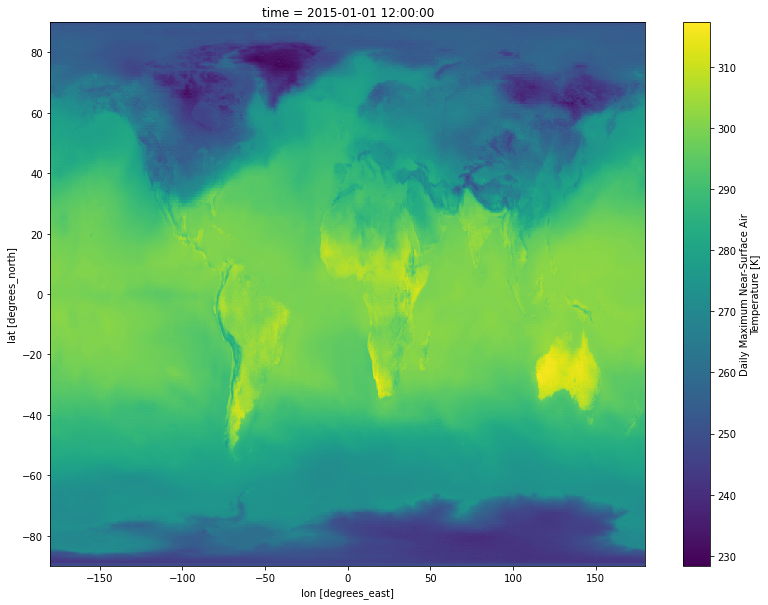

In [9]:
tmax = ds.tasmax.isel(time=0).load()
tmax.plot(size=10);